# MNIST on TPU

In [22]:
# ! pip install matplotlib

In [2]:
import os

Before starting, instruct your python kernel to use the TPU accelerator by setting the `XRT_TPU_CONFIG` env var. We set TPU config using the address to host process for TPU cores on your VM. <br><br> `XLA_USE_BF16=1` instructs PyTorch to use the bFloat16 format, rather than Float32. This will maximize TPU performance.

In [1]:
%env XRT_TPU_CONFIG=localservice;0;localhost:51011
%env XLA_USE_BF16=1

env: XRT_TPU_CONFIG=localservice;0;localhost:51011
env: XLA_USE_BF16=1


In [5]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [6]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.01
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [7]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### REQUIRED TORCH XLA LIBRARIES FOR TPU
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu


from torchvision import datasets, transforms


SERIAL_EXEC = xmp.MpSerialExecutor()

class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Only instantiate model weights once in memory.
### Wraps a model to minimize host memory usage when fork method is used.
WRAPPED_MODEL = xmp.MpModelWrapper(MNIST())

def train_mnist():
  torch.manual_seed(1)
  
  def get_dataset():
    norm = transforms.Normalize((0.1307,), (0.3081,))
    train_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    test_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    
    return train_dataset, test_dataset
  
  # Using the serial executor avoids multiple processes to
  # download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  ### Sampler that restricts data loading to a subset of the dataset, used with DistributedDataParellel
  ### Each process is passed a DistributedSampler instance and can load its own subset of the original data.
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  ### IMPORTANT: INITIALIZE XLA DEVICE, TRANSFER MODEL
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      
      ### SPECIFY TORCH XLA OPTIMIZER
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target

In [8]:
# Start training processes
### SPAWN MULTIPROCESS TRAINING LOOP
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

[xla:0](0) Loss=2.32812 Rate=80.28 GlobalRate=80.28 Time=Thu Aug  4 21:09:49 2022
[xla:3](0) Loss=2.32812 Rate=361.83 GlobalRate=361.82 Time=Thu Aug  4 21:09:58 2022
[xla:2](0) Loss=2.34375 Rate=531.15 GlobalRate=531.14 Time=Thu Aug  4 21:09:58 2022
[xla:7](0) Loss=2.29688 Rate=538.74 GlobalRate=538.70 Time=Thu Aug  4 21:09:58 2022
[xla:6](0) Loss=2.32812 Rate=440.13 GlobalRate=440.12 Time=Thu Aug  4 21:09:59 2022
[xla:4](0) Loss=2.34375 Rate=507.84 GlobalRate=507.82 Time=Thu Aug  4 21:09:59 2022
[xla:1](0) Loss=2.35938 Rate=517.68 GlobalRate=517.67 Time=Thu Aug  4 21:10:00 2022
[xla:5](0) Loss=2.32812 Rate=488.42 GlobalRate=488.41 Time=Thu Aug  4 21:10:02 2022
[xla:0](20) Loss=0.45898 Rate=135.44 GlobalRate=163.30 Time=Thu Aug  4 21:10:04 2022[xla:2](20) Loss=0.40625 Rate=445.11 GlobalRate=392.79 Time=Thu Aug  4 21:10:04 2022

[xla:6](20) Loss=0.31836 Rate=471.85 GlobalRate=490.19 Time=Thu Aug  4 21:10:

Finished training epoch 7
[xla:7] Accuracy=98.58%
[xla:2] Accuracy=98.57%
[xla:4] Accuracy=98.57%
[xla:5] Accuracy=98.57%
[xla:3] Accuracy=98.57%
[xla:6] Accuracy=98.58%
[xla:1] Accuracy=98.59%
[xla:0] Accuracy=98.59%
[xla:5](0) Loss=0.03247 Rate=174.15 GlobalRate=174.15 Time=Thu Aug  4 21:10:23 2022
[xla:7](0) Loss=0.07715 Rate=161.62 GlobalRate=161.62 Time=Thu Aug  4 21:10:23 2022[xla:2](0) Loss=0.07031 Rate=162.48 GlobalRate=162.48 Time=Thu Aug  4 21:10:23 2022

[xla:4](0) Loss=0.04346 Rate=162.34 GlobalRate=162.34 Time=Thu Aug  4 21:10:23 2022[xla:1](0) Loss=0.04199 Rate=252.85 GlobalRate=252.84 Time=Thu Aug  4 21:10:23 2022
[xla:6](0) Loss=0.06934 Rate=164.28 GlobalRate=164.28 Time=Thu Aug  4 21:10:23 2022

[xla:3](0) Loss=0.01917 Rate=164.32 GlobalRate=164.32 Time=Thu Aug  4 21:10:23 2022
[xla:0](0) Loss=0.04077 Rate=326.52 GlobalRate=326.51 Time=Thu Aug  4 21:10:23 2022
[xla:0](20) Loss=0.09619 Rate=7277.28 GlobalRate=4428.67 Time=Thu Aug  4 21:10:23 2022[xla:1](20) Loss=0.00958

# Visualize

In [21]:
# ! pip install opencv-python
# ! pip install opencv-contrib-python-headless

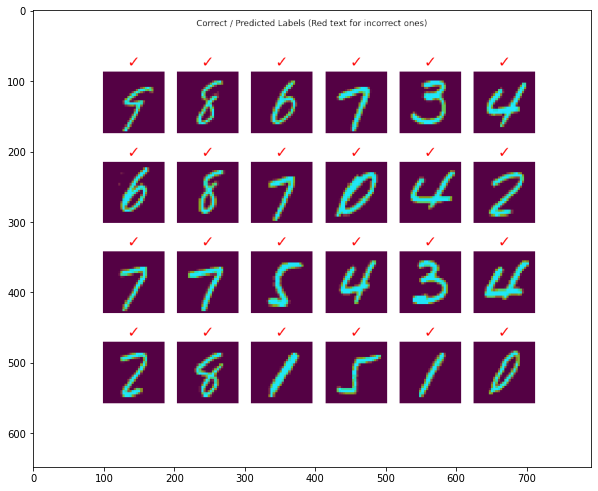

In [20]:
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(10,10))
plt.imshow(img)